# Imports

In [1]:
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm
import os
import numpy as np
import plotly.express as px

from io import BytesIO
from zipfile import ZipFile
from subprocess import call, STDOUT
from urllib.request import urlopen


import requests
from matplotlib import cm, colors
from IPython.display import Image
import pandas as pd
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
from Bio.PDB import PDBParser, PDBIO
import nglview as nv

from plipify.fingerprints import InteractionFingerprint
from plipify.visualization import (
    fingerprint_barplot, fingerprint_heatmap, fingerprint_table, 
    fingerprint_nglview, PymolVisualizer, nglview_color_side_chains_by_frequency,
    fingerprint_writepdb
)
from plipify.core import Structure

In [9]:
import importlib

In [10]:
importlib.reload(px)

<module 'plotly.express' from '/Users/alexpayne/opt/anaconda3/envs/plipify/lib/python3.8/site-packages/plotly/express/__init__.py'>

## paths

In [12]:
# input_glob = "/Volumes/Rohirrim/local_test/full_frag_prepped_mpro_20221219/*/prepped_receptor_0.pdb"
# input_glob = "/Volumes/Rohirrim/local_test/full_frag_prepped_mpro_20221219/*/prepped_receptor_0.pdb"
# output_path = Path("/Volumes/Rohirrim/local_test/plipify_result")
output_path = Path("/Volumes/Rohirrim/local_test/plipify_result_v2")
if not output_path.exists():
    Path.mkdir(output_path)

In [13]:
plipify_results_path = output_path / 'plipify_results.csv'

## pocket definitions

In [14]:
pocket_definitions = {'P1': np.array([140,
                             141,
                             142,
                             143,
                             144,
                             145,
                             163,
                                      164,
                             172]),
                      'P1_prime': np.array([25,26,27]),
                      'P2': np.array([41,49,54, 187]),
                      'P3_4_5': np.array([165,166,167,168,189,190,191,192])}

# Load Structures

In [ ]:
structure_paths = [Path(fn) for fn in glob(input_glob)]
# structure_paths = structure_paths[0:10]
print(len(structure_paths))

In [ ]:
mypath = structure_paths[0]

In [ ]:
mypath.parent.name

## make new protein fns and load

In [ ]:
new_paths = [structure_path.with_name(structure_path.parent.name).with_suffix(structure_path.suffix) for structure_path in structure_paths]
print(len(new_paths))

In [ ]:
## make new filenames and load structure objects
structures = []
for structure_path, new_path in tqdm(zip(structure_paths, new_paths), total=len(structure_paths)):
    if not new_path.exists():
        shutil.copy(structure_path, new_path)
    structures.append(Structure.from_pdbfile(str(new_path), ligand_name="LIG"))
print(f"Loaded {len(structures)} structures.")

# Calculate Fingerprint

In [ ]:
## A bunch of filtering
lengths = pd.DataFrame([((s.identifier), len(s.sequence())) for s in structures], columns=["identifier", "length"])
# Remove entries where the difference sequence length - median sequence length is greater than one standard deviation
print('Sequence length median and std: ', lengths.length.median(), lengths.length.std())

In [ ]:
lengths = lengths[(lengths.length - lengths.length.median()).abs() < lengths.length.std()]
filtered_structures = [s for s in structures if s.identifier in set(lengths.identifier.tolist())]
print(len(structure_fns), "->", len(structures), "->", len(filtered_structures), "=", len(structure_fns) - len(filtered_structures),
      "structures filtered out")

structure_name_type_dict = {'Mpro-P': 0, 'Mpro-x': 0, 'Mpro-z': 0, 'other': 0}
print(structure_name_type_dict.keys())
for s in structures:
    name_code = s.identifier[0:6]
    print(name_code)
    if name_code in structure_name_type_dict.keys():
        structure_name_type_dict[name_code] += 1
    else:
        structure_name_type_dict['other'] += 1
print(structure_name_type_dict)

In [ ]:
# Review
fp = InteractionFingerprint().calculate_fingerprint(
    filtered_structures,
    labeled=True,
    as_dataframe=True,
    remove_non_interacting_residues=True,
    remove_empty_interaction_types=True,
    ensure_same_sequence=False
)

## filter results

In [ ]:
# filter out some of the low counts
fp_focused = fp[fp.sum(axis=1) > 5]

## write out csv file

In [ ]:
fp_focused.to_csv(plipify_results_path)

In [26]:
fp_focused = pd.read_csv(plipify_results_path, index_col=0)

In [27]:
type(fp_focused)

pandas.core.frame.DataFrame

In [28]:
fp_focused.style.background_gradient(axis=None, cmap="YlGnBu")

,hydrophobic,hbond-don,hbond-acc,pistacking,pication
25,4,0,0,0,0
41,7,1,3,25,5
44,0,0,1,0,0
49,5,0,0,0,0
94,1,0,0,0,0
140,0,0,2,0,0
142,13,4,5,0,0
143,0,17,1,0,0
144,0,7,0,0,0
145,0,9,0,0,0


## add pocket info to fp dataframe

In [29]:
fp_focused.index

Int64Index([25, 41, 44, 49, 94, 140, 142, 143, 144, 145, 164, 165, 166, 172,
            187, 189, 192],
           dtype='int64')

In [30]:
fp_focused.index.isin(pocket_definitions['P1'])

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False,  True, False, False, False])

In [31]:
for pocket, resarray in pocket_definitions.items():
    fp_focused.loc[fp_focused.index.isin(resarray), 'Pocket'] = pocket

In [32]:
fp_focused

,hydrophobic,hbond-don,hbond-acc,pistacking,pication,Pocket
25,4,0,0,0,0,P1_prime
41,7,1,3,25,5,P2
44,0,0,1,0,0,NaN
49,5,0,0,0,0,P2
94,1,0,0,0,0,NaN
140,0,0,2,0,0,P1
142,13,4,5,0,0,P1
143,0,17,1,0,0,P1
144,0,7,0,0,0,P1
145,0,9,0,0,0,P1


## not cumulative

In [24]:
# Review
fp_not_cumulative = InteractionFingerprint().calculate_fingerprint(
    filtered_structures,
    cumulative=False,
    labeled=True,
    as_dataframe=True,
    remove_non_interacting_residues=True,
    remove_empty_interaction_types=True,
    ensure_same_sequence=False
)

NameError: name 'filtered_structures' is not defined

In [ ]:
np.shape(fp_not_cumulative)

In [ ]:
fp_not_cumulative[0][0].label['residue'].structure.identifier

In [ ]:
fp_not_cumulative[0][0].label['residue'].seq_index

# which structures are returning non labeled active site residues?

In [ ]:
wacky_residues = fp_focused.index[fp_focused.Pocket.isna()]

In [ ]:
wacky_interactions = []
for structure in fp_not_cumulative:
    for interaction in structure:
        if interaction.label['residue'].seq_index in wacky_residues:
            if interaction.value > 0:
                wacky_interactions.append(interaction)

In [ ]:
wacky_structures = []
for interaction in wacky_interactions:
    print(interaction.label['residue'].identifier, 
          interaction.value, interaction.label['type'],
          interaction.label['residue'].structure.identifier)
    wacky_structures.append(interaction.label['residue'].structure.identifier)

In [ ]:
set(wacky_structures)

# Visualization

## Analyze and visualize the results

* First, we will look at the different representations for the interation hot spots.
* Then, we will visualize the interactions in 3D
    * nglview
    * pymol

### Interaction visualizations: Barplot, heatmap and table

`plipify` provides several views for the aggregated interaction fingerprints.

#### Barplot

In [33]:
fingerprint_barplot(fp_focused)

#### Heatmap

ValueError: could not convert string to float: 'P1_prime'

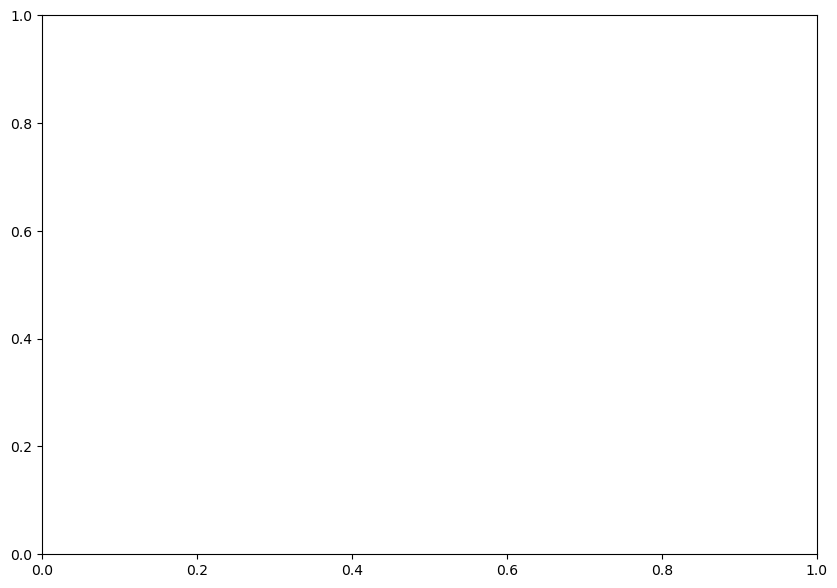

In [34]:
fingerprint_heatmap(fp_focused, cmap="YlGnBu");

#### Table
Reminder: we did not use structrue[0] during calculation because of the occuring mutation.

In [35]:
mytable = fingerprint_table(fingerprint_df=fp_focused, structure=structures[0])

NameError: name 'structures' is not defined

In [ ]:
mytable

In [ ]:
type(mytable)

In [ ]:
mytable.

In [ ]:
from ipywidgets.embed import embed_minimal_html

In [ ]:
embed_minimal_html("plipify.html", mytable)

## split by pocket

In [ ]:
import plotly.express as px

In [ ]:
fp_px = fp_focused.replace(np.nan, "Other")

In [ ]:
normalized = fp_px / fp_px.sum()

In [ ]:
fp_px.sum(axis=1, numeric_only=True)

In [ ]:
fp_focused

In [ ]:
normalized = fp_focused.drop(columns=["Pocket"])

In [ ]:
fp_px = normalized.divide(normalized.sum(axis=1, numeric_only=True), axis=0)
fp_px['Pocket'] = fp_focused['Pocket']

In [ ]:
fp_px = fp_px.replace(np.nan, "Other")
fp_focused['ResID'] = fp_focused.index

In [ ]:
fp_px = fp_focused.melt(id_vars=['ResID', 'Pocket'], var_name='Type', value_name='Count')
fp_px = fp_px.replace(np.nan, "Other")
fp_px.sort_values('ResID')
# fp_px = fp_px[fp_px.Count > 10]
fp_px = fp_px[fp_px.Pocket != 'Other']
fig = px.bar(fp_px, x='ResID', y='Count', color='Type', facet_row='Pocket', 
             height=1200, width=800, category_orders = {'Pocket': pocket_definitions.keys()}, 
             text_auto=True, 
             barmode='group'
            )
fig.update_xaxes(type='category', matches=None, showticklabels=True)
# fig.update_yaxes(matches=None)
fig.update_traces(textposition="auto", cliponaxis=False)
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='show')
# fig.write_image("plipify_pocket_faceted.png")

In [ ]:
for pocket, array in pocket_definitions.items():
    df = fp_px[fp_px['Pocket'] == pocket].drop(columns='Pocket')
    fig = px.bar(df, x='ResID', y='Count', color='Type')
    fig.update_xaxes(type='category')
    fig.show()